# Importación de librerías y salida inicial de la data

In [1]:
#Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
%matplotlib inline
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

#Cargando la data
data=pd.read_csv('petroleo.csv')
data.head()

,fecha,ultimo,apertura,maximo,minimo,vol,var
0,2003-01-02,31.85,31.60,32.09,31.40,62480.0,2.08
1,2003-01-03,33.08,31.98,33.25,31.90,68420.0,3.86
2,2003-01-06,32.10,33.08,33.33,31.91,98250.0,-2.96
3,2003-01-07,31.08,32.11,32.40,30.51,124280.0,-3.18
4,2003-01-08,30.56,31.05,31.30,29.75,108040.0,-1.67


In [2]:
#En series de tiempo, se debe tener la fecha como índice
data['fecha'] = pd.to_datetime(data.fecha,format='%Y-%m-%d')
data.index = data['fecha']

#Obtener la data de manera ascendente en el tiempo
data = data.sort_index(ascending=True, axis=0)
data.head()

,fecha,ultimo,apertura,maximo,minimo,vol,var
fecha,,,,,,,
2003-01-02,2003-01-02,31.85,31.60,32.09,31.40,62480.0,2.08
2003-01-03,2003-01-03,33.08,31.98,33.25,31.90,68420.0,3.86
2003-01-06,2003-01-06,32.10,33.08,33.33,31.91,98250.0,-2.96
2003-01-07,2003-01-07,31.08,32.11,32.40,30.51,124280.0,-3.18
2003-01-08,2003-01-08,30.56,31.05,31.30,29.75,108040.0,-1.67


# Linear Regression para series de tiempo

In [7]:
#Crear un dataset con el outcome y las variables de entrada
new_data = pd.DataFrame(index=range(0,len(data)),columns=['fecha', 'ultimo'])

for i in range(0,len(data)):
    new_data['fecha'][i] = data['fecha'][i]
    new_data['ultimo'][i] = data['ultimo'][i]
new_data.index = new_data['fecha']

In [8]:
#Creación de features para la predicción de TS considerando la fecha como punto de partida

import pandas as pd,re
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
#Aplicación de la función al dataset predictor
add_datepart(new_data, 'fecha')
new_data.drop('fechaElapsed', axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
#Separación del dataset en train y test. Como son TS se toma como predictor los años anteriores y se deja el último año 2018 como outcome
train = new_data[:3819]
test = new_data[3819:]

#Extracción de las variables no útiles, solo se deja las predictoras.
x_train = train.drop('ultimo', axis=1)
y_train = train['ultimo']
x_test = test.drop('ultimo', axis=1)
y_test = test['ultimo']

#Implementación del modelo de regresión lineal
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
#Cálculo de predicciones y determinación del error cuadrático
preds = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

14.371287676310894

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


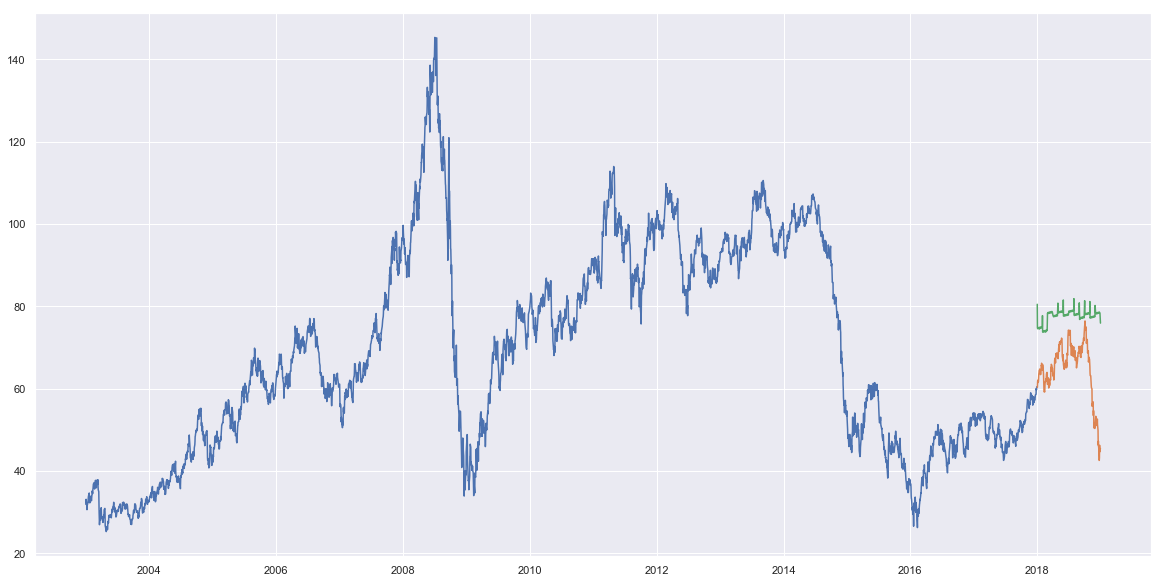

In [117]:
#Gráfica de las predicciones, con la TS predictora, el outcome original y el outcome predicho
test['Predictions'] = preds

test.index = new_data[3819:].index
train.index = new_data[:3819].index

plt.plot(train['ultimo'])
plt.plot(test[['ultimo', 'Predictions']])

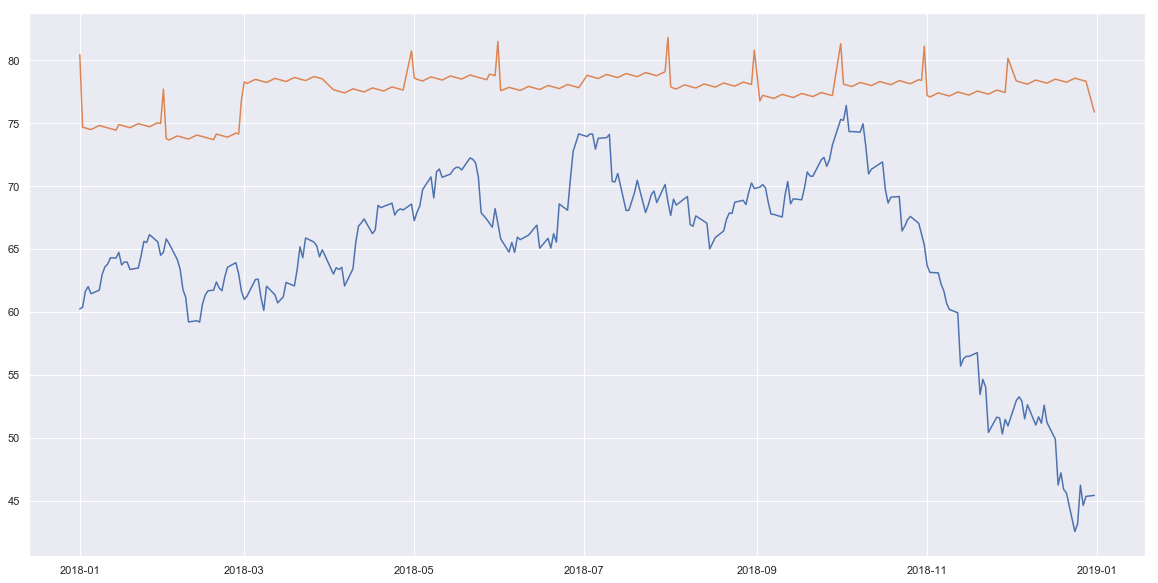

In [118]:
#Gráfica del outcome original y del outcome predicho
plt.plot(test[['ultimo','Predictions']])

In [119]:
#Coeficientes del modelo y coeficiente de determinación
model.coef_,model.score(x_train,y_train)

(array([ 1.05543837e+00,  5.39639258e+01,  1.34610927e-01,  1.77706755e+00,
        -5.35624436e-02, -1.78572600e+00,  2.78648303e+00,  5.44766876e-02,
        -4.03540626e+00,  3.10268810e+00,  5.47680933e+00,  2.55700314e+00]),
 0.037572910956972794)

# K-NN para series de tiempo

In [5]:
#Librerias importadas
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [11]:
#Es necesario escalar la data antes de someter a la predicción
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

#Iteración en el número de grupos hasta encontrar los mejores k grupos
#Hacer crossvalidation para asegurar calidad en la predicción
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=10)

#Ajustar el modelo y calcular las predicciones
model.fit(x_train,y_train)
model.best_params_
preds = model.predict(x_test)
model.best_params_

{'n_neighbors': 5}

In [127]:
#Cálculo del error cuadrático del modelo ajustado
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

25.849110536833845

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


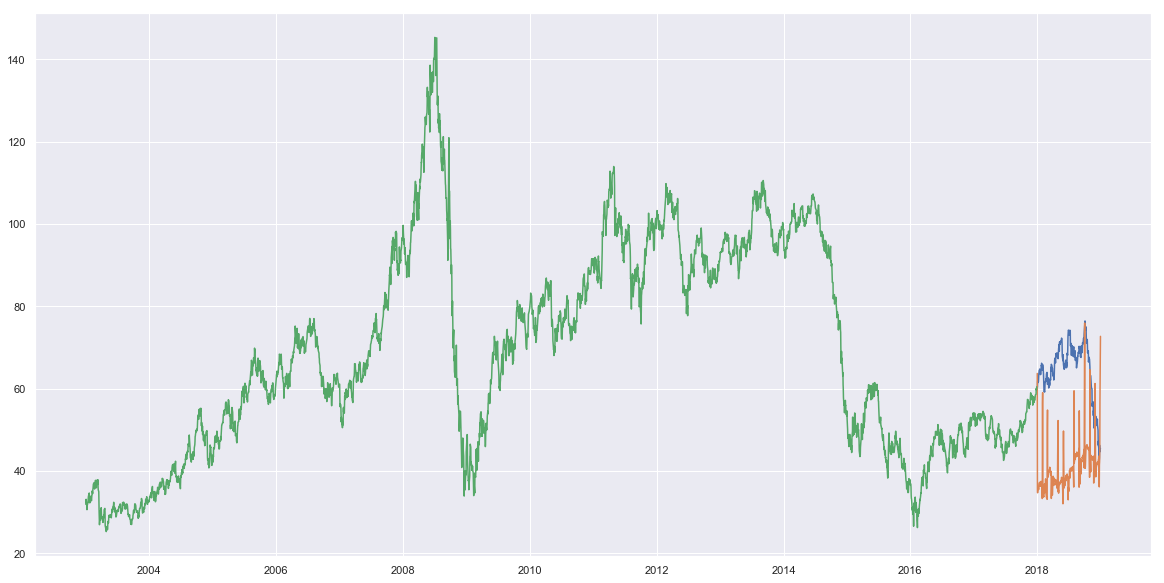

In [128]:
#Gráfica de las prediciones, los datos predictores y el outcome. 
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(test[['ultimo', 'Predictions']])
plt.plot(train['ultimo'])

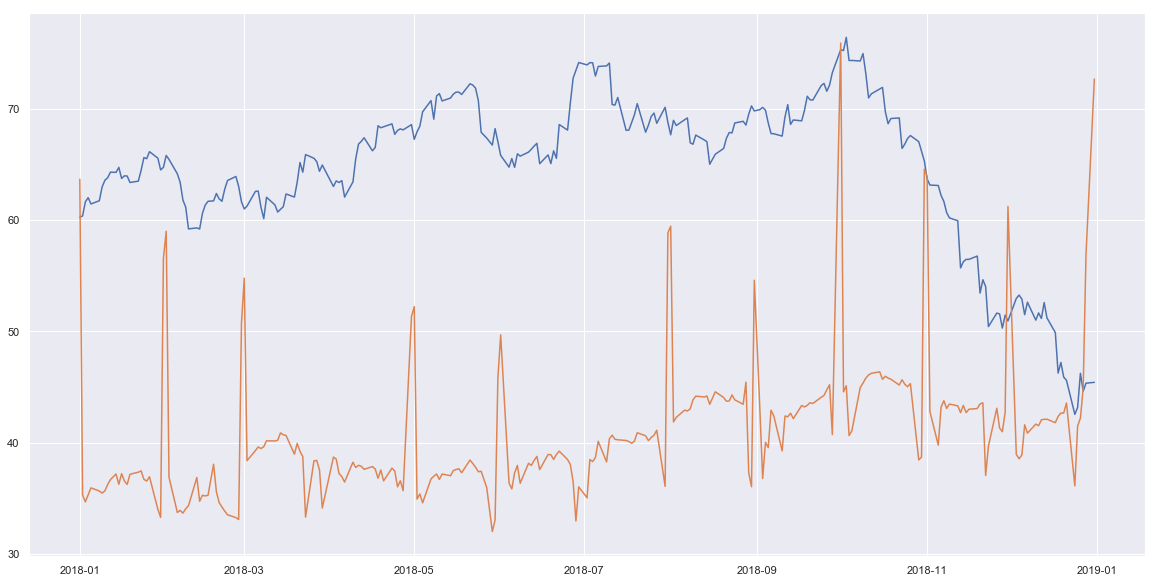

In [129]:
#Gráfica del outcome original y del outcome predicho
plt.plot(test[['ultimo','Predictions']])